## When to Promote? A Bayesian Hypotheis Testing Framework
In this notebook, we explore which weekday is the best day to rollout high promotional activity

### Approach: 
1) Subset data for 'Wine, Liquor and Beer' and store number 44
2) We subset data after 01Jan2016 as promotional activity is not present prior to that
3) We exclude weekdays and Holidays from the dataset
4) we use student t-test to check the best possible day to roll out high promotinal activity
5) We use PyMC3 to estimate posterior probability for each day of the week to determine the chance of achieving above average sales if High Promotional activity was rolled out

### Import Packages

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm

WARN: Could not locate executable g77
WARN: Could not locate executable f77
WARN: Could not locate executable ifort
WARN: Could not locate executable ifl
WARN: Could not locate executable f90
WARN: Could not locate executable DF
WARN: Could not locate executable efl
WARN: Could not locate executable gfortran
WARN: Could not locate executable f95
WARN: Could not locate executable g95
WARN: Could not locate executable efort
WARN: Could not locate executable efc
WARN: Could not locate executable flang
WARN: don't know how to compile Fortran code on platform 'nt'


WARNING (theano.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (theano.configdefaults): g++ not detected ! Theano will be unable to execute optimized C-implementations (for both CPU and GPU) and will default to Python implementations. Performance will be severely degraded. To remove this warning, set Theano flags cxx to an empty string.
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


### Import dataset. You can download the dataset from Kaggle too from the below link

https://www.kaggle.com/code/giangnh/store-sales-time-series-forecasting/input

In [5]:
df_transaction=pd.read_csv('train.csv')
df_transaction.head()

,id,date,store_nbr,family,sales,onpromotion
0,0,2013-01-01,1,AUTOMOTIVE,0.0,0
1,1,2013-01-01,1,BABY CARE,0.0,0
2,2,2013-01-01,1,BEAUTY,0.0,0
3,3,2013-01-01,1,BEVERAGES,0.0,0
4,4,2013-01-01,1,BOOKS,0.0,0


In [6]:
df_transaction['family'].nunique

<bound method IndexOpsMixin.nunique of 0                          AUTOMOTIVE
1                           BABY CARE
2                              BEAUTY
3                           BEVERAGES
4                               BOOKS
                      ...            
3000883                       POULTRY
3000884                PREPARED FOODS
3000885                       PRODUCE
3000886    SCHOOL AND OFFICE SUPPLIES
3000887                       SEAFOOD
Name: family, Length: 3000888, dtype: object>

### For the current problem statement, we only consider Liquor, Wine and Beer Category

In [7]:
df_transaction_subset=df_transaction[(df_transaction['family']=='LIQUOR,WINE,BEER') ]
df_transaction_subset.head()

,id,date,store_nbr,family,sales,onpromotion
22,22,2013-01-01,1,"LIQUOR,WINE,BEER",0.0,0
55,55,2013-01-01,10,"LIQUOR,WINE,BEER",0.0,0
88,88,2013-01-01,11,"LIQUOR,WINE,BEER",0.0,0
121,121,2013-01-01,12,"LIQUOR,WINE,BEER",0.0,0
154,154,2013-01-01,13,"LIQUOR,WINE,BEER",0.0,0


In [8]:
df_transaction_subset.groupby(['store_nbr']).sum().sort_values(by=['onpromotion'],ascending=False)

,id,date,family,sales,onpromotion
store_nbr,,,,,
44,2527396036,2013-01-012013-01-022013-01-032013-01-042013-0...,"LIQUOR,WINE,BEERLIQUOR,WINE,BEERLIQUOR,WINE,BE...",553902.0,1659
53,2527951756,2013-01-012013-01-022013-01-032013-01-042013-0...,"LIQUOR,WINE,BEERLIQUOR,WINE,BEERLIQUOR,WINE,BE...",116026.0,1566
49,2527673896,2013-01-012013-01-022013-01-032013-01-042013-0...,"LIQUOR,WINE,BEERLIQUOR,WINE,BEERLIQUOR,WINE,BE...",366079.0,1510
45,2527451608,2013-01-012013-01-022013-01-032013-01-042013-0...,"LIQUOR,WINE,BEERLIQUOR,WINE,BEERLIQUOR,WINE,BE...",350532.0,1477
47,2527562752,2013-01-012013-01-022013-01-032013-01-042013-0...,"LIQUOR,WINE,BEERLIQUOR,WINE,BEERLIQUOR,WINE,BE...",280368.0,1445
3,2526506884,2013-01-012013-01-022013-01-032013-01-042013-0...,"LIQUOR,WINE,BEERLIQUOR,WINE,BEERLIQUOR,WINE,BE...",369712.0,1406
50,2527785040,2013-01-012013-01-022013-01-032013-01-042013-0...,"LIQUOR,WINE,BEERLIQUOR,WINE,BEERLIQUOR,WINE,BE...",190695.0,1244
46,2527507180,2013-01-012013-01-022013-01-032013-01-042013-0...,"LIQUOR,WINE,BEERLIQUOR,WINE,BEERLIQUOR,WINE,BE...",202772.0,1244
8,2528174044,2013-01-012013-01-022013-01-032013-01-042013-0...,"LIQUOR,WINE,BEERLIQUOR,WINE,BEERLIQUOR,WINE,BE...",248567.0,1221


### For the current problem statement we subset the data for Store 44

In [11]:
df_transaction_subset=df_transaction_subset[df_transaction_subset['store_nbr']==44]
df_transaction_subset.head(10)

,id,date,store_nbr,family,sales,onpromotion
1276,1276,2013-01-01,44,"LIQUOR,WINE,BEER",0.0,0
3058,3058,2013-01-02,44,"LIQUOR,WINE,BEER",250.0,0
4840,4840,2013-01-03,44,"LIQUOR,WINE,BEER",207.0,0
6622,6622,2013-01-04,44,"LIQUOR,WINE,BEER",284.0,0
8404,8404,2013-01-05,44,"LIQUOR,WINE,BEER",478.0,0
10186,10186,2013-01-06,44,"LIQUOR,WINE,BEER",0.0,0
11968,11968,2013-01-07,44,"LIQUOR,WINE,BEER",157.0,0
13750,13750,2013-01-08,44,"LIQUOR,WINE,BEER",159.0,0
15532,15532,2013-01-09,44,"LIQUOR,WINE,BEER",199.0,0
17314,17314,2013-01-10,44,"LIQUOR,WINE,BEER",186.0,0


## Here we consider highest number of products on promotions. We classify the >25% of the highest number of products on promotions as low promotional activity and <25% as high promotional activity

In [12]:
import pandas as pd

def classify_distribution(df, column_name):
    # Get the unique elements in the column
    unique_values = df[column_name].unique()

    # Sort the unique values
    unique_values.sort()

    # Calculate quartiles
    num_unique_values = max(unique_values)
    print(num_unique_values)
    q25_index = num_unique_values // 4
    q50_index = num_unique_values // 2
    q75_index = (3 * num_unique_values) // 4
    print(q25_index)

    # Define classification thresholds
    zero_threshold = 0
    low_threshold = q25_index
    medium_threshold = q50_index
    large_threshold = q75_index

    # Classify values based on the thresholds
    def classify(value):
        if value == zero_threshold:
            return '0'
        elif value>0 and value <= low_threshold:
            return 'low'
        elif value> low_threshold and value <= medium_threshold:
            return 'medium'
        else:
            return 'large'

    # Create a new column with the classifications
    df['Classified_promo_3'] = df[column_name].apply(classify)

    return df

df_transaction_subset_new=classify_distribution(df_transaction_subset, 'onpromotion')
df_transaction_subset_new.head()

14
3


,id,date,store_nbr,family,sales,onpromotion,Classified_promo_3
1276,1276,2013-01-01,44,"LIQUOR,WINE,BEER",0.0,0,0
3058,3058,2013-01-02,44,"LIQUOR,WINE,BEER",250.0,0,0
4840,4840,2013-01-03,44,"LIQUOR,WINE,BEER",207.0,0,0
6622,6622,2013-01-04,44,"LIQUOR,WINE,BEER",284.0,0,0
8404,8404,2013-01-05,44,"LIQUOR,WINE,BEER",478.0,0,0


### EDA

### Box plot and Histogram to check the distribution of the number of products on promtions

In [13]:
df_transaction_subset_new['onpromotion'].unique()

array([ 0,  1,  3,  4,  2,  7,  6,  5,  8, 11, 13, 14,  9, 12, 10],
      dtype=int64)

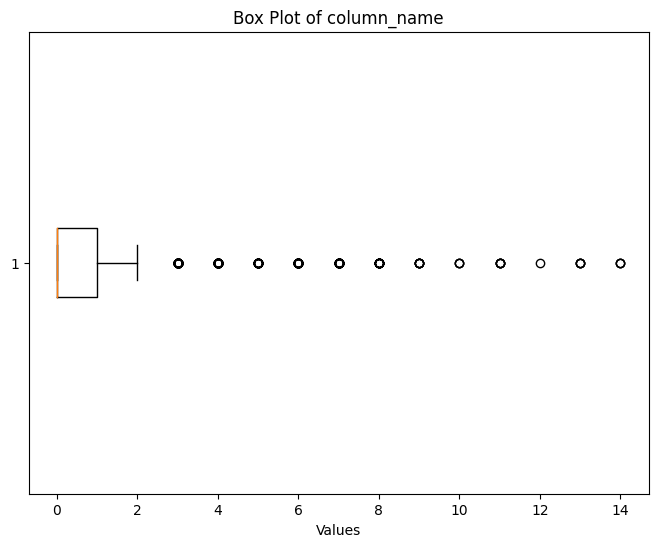

In [14]:
import matplotlib.pyplot as plt
df_sub=df_transaction_subset_new[df_transaction_subset_new['date']>='01-01-2016']

# Assuming df is your DataFrame and 'column_name' is the column for which you want to create a box plot
# Example DataFrame creation

# Create a box plot
plt.figure(figsize=(8, 6))
plt.boxplot(df_sub['onpromotion'], vert=False)  # vert=False for horizontal box plot
plt.title('Box Plot of column_name')
plt.xlabel('Values')
plt.show()


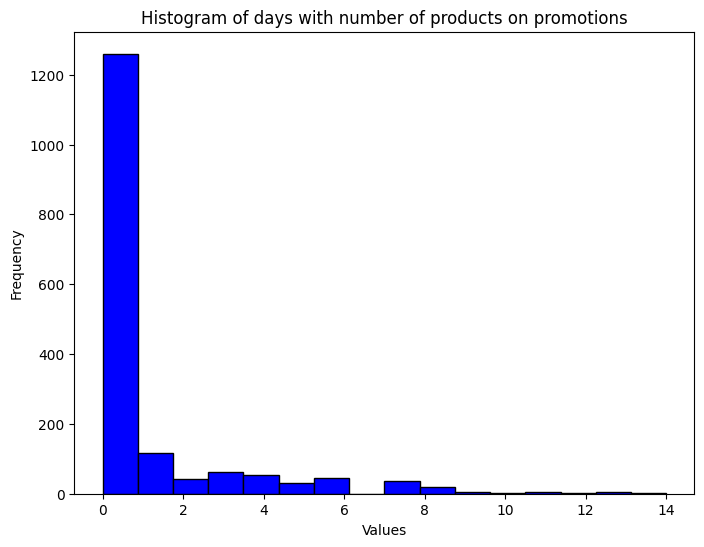

In [15]:
# Create a histogram
plt.figure(figsize=(8, 6))
plt.hist(df_sub['onpromotion'], bins=16, color='blue', edgecolor='black')  # Adjust the number of bins as needed
plt.title('Histogram of days with number of products on promotions')
plt.xlabel('Values')
plt.ylabel('Frequency')
plt.show()

In [16]:
df_transaction_subset_new.groupby('Classified_promo_3')['onpromotion'].unique()

Classified_promo_3
0                                [0]
large     [8, 11, 13, 14, 9, 12, 10]
low                        [1, 3, 2]
medium                  [4, 7, 6, 5]
Name: onpromotion, dtype: object

In [17]:
df_transaction_subset_new['date'] = pd.to_datetime(df_transaction_subset_new['date'], format='%Y-%m-%d')
df_transaction_subset_new['day_of_the_week']=df_transaction_subset_new['date'].dt.day_name()
df_transaction_subset_new.head()

,id,date,store_nbr,family,sales,onpromotion,Classified_promo_3,day_of_the_week
1276,1276,2013-01-01,44,"LIQUOR,WINE,BEER",0.0,0,0,Tuesday
3058,3058,2013-01-02,44,"LIQUOR,WINE,BEER",250.0,0,0,Wednesday
4840,4840,2013-01-03,44,"LIQUOR,WINE,BEER",207.0,0,0,Thursday
6622,6622,2013-01-04,44,"LIQUOR,WINE,BEER",284.0,0,0,Friday
8404,8404,2013-01-05,44,"LIQUOR,WINE,BEER",478.0,0,0,Saturday


### Considering data after 01 Jan 2016

In [21]:
df_transaction_subset_new=df_transaction_subset_new[df_transaction_subset_new['date']>='2016-01-01']
df_transaction_subset_new.head()

,id,date,store_nbr,family,sales,onpromotion,Classified_promo_3,day_of_the_week,new_flag
1947220,1947220,2016-01-01,44,"LIQUOR,WINE,BEER",0.0,0,0,Friday,Low Promotional
1949002,1949002,2016-01-02,44,"LIQUOR,WINE,BEER",431.0,0,0,Saturday,Low Promotional
1950784,1950784,2016-01-03,44,"LIQUOR,WINE,BEER",0.0,0,0,Sunday,Low Promotional
1952566,1952566,2016-01-04,44,"LIQUOR,WINE,BEER",261.0,0,0,Monday,Low Promotional
1954348,1954348,2016-01-05,44,"LIQUOR,WINE,BEER",299.0,0,0,Tuesday,Low Promotional


### Average daily sales for different categories of promotions

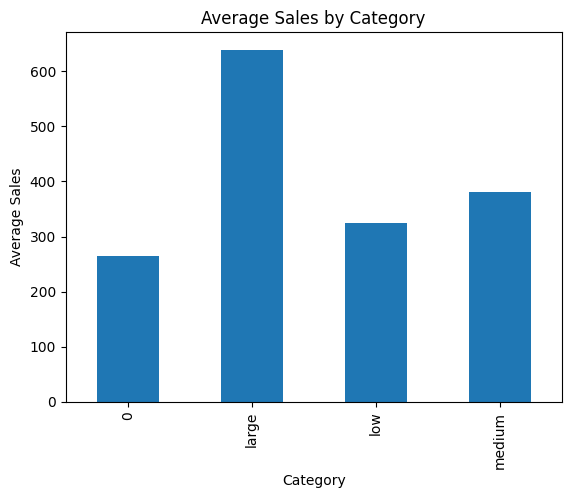

In [22]:
import matplotlib.pyplot as plt
average_sales = df_transaction_subset_new.groupby('Classified_promo_3')['sales'].mean()

# Plot the average sales
average_sales.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Average Sales')
plt.title('Average Sales by Category')
plt.show()

#### we can see that the average sales for days with large and medium categories of products on promotions are larger than days with medium, low and 0 products on promotions

In [23]:
df_transaction_subset_new['new_flag']=((df_transaction_subset_new['Classified_promo_3']=='medium') | (df_transaction_subset_new['Classified_promo_3']=='large'))
df_transaction_subset_new.replace({True: 'High Promotional', False: 'Low Promotional'}, inplace=True)
df_transaction_subset_new.head()

,id,date,store_nbr,family,sales,onpromotion,Classified_promo_3,day_of_the_week,new_flag
1947220,1947220,2016-01-01,44,"LIQUOR,WINE,BEER",0.0,0,0,Friday,Low Promotional
1949002,1949002,2016-01-02,44,"LIQUOR,WINE,BEER",431.0,0,0,Saturday,Low Promotional
1950784,1950784,2016-01-03,44,"LIQUOR,WINE,BEER",0.0,0,0,Sunday,Low Promotional
1952566,1952566,2016-01-04,44,"LIQUOR,WINE,BEER",261.0,0,0,Monday,Low Promotional
1954348,1954348,2016-01-05,44,"LIQUOR,WINE,BEER",299.0,0,0,Tuesday,Low Promotional


### We now classify days with 0, Low products on promotions as "Low Promotional activity" and Products with Medium and High products on promotions as "High Promotional activity"

#### Let's have a look at the average sales for High and Low promotional activity

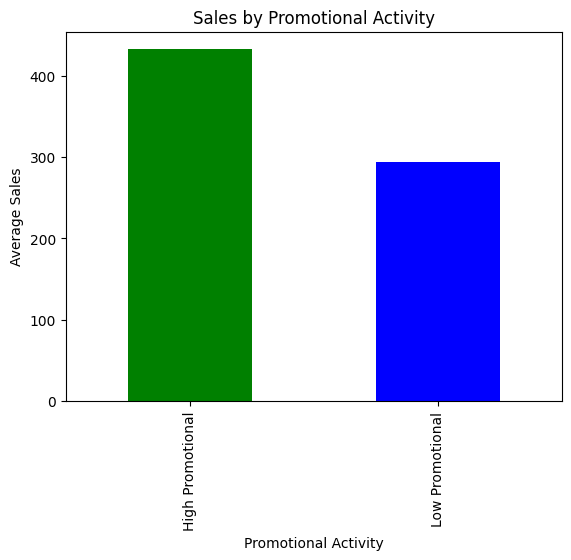

In [24]:
sales_by_flag = df_transaction_subset_new.groupby('new_flag')['sales'].mean()
sales_by_flag.plot(kind='bar', color=['green', 'blue'])
plt.title('Sales by Promotional Activity')
plt.xlabel('Promotional Activity')
plt.ylabel('Average Sales')
plt.show()

### Let's analyse the average sales by different days of the week and promotional activity

In [26]:
holiday_df=pd.read_csv('holidays_events.csv')
holiday_df['date'] = pd.to_datetime(holiday_df['date'], format='%Y-%m-%d')
holiday_df

,date,type,locale,locale_name,description,transferred
0,2012-03-02,Holiday,Local,Manta,Fundacion de Manta,False
1,2012-04-01,Holiday,Regional,Cotopaxi,Provincializacion de Cotopaxi,False
2,2012-04-12,Holiday,Local,Cuenca,Fundacion de Cuenca,False
3,2012-04-14,Holiday,Local,Libertad,Cantonizacion de Libertad,False
4,2012-04-21,Holiday,Local,Riobamba,Cantonizacion de Riobamba,False
...,...,...,...,...,...,...
345,2017-12-22,Additional,National,Ecuador,Navidad-3,False
346,2017-12-23,Additional,National,Ecuador,Navidad-2,False
347,2017-12-24,Additional,National,Ecuador,Navidad-1,False
348,2017-12-25,Holiday,National,Ecuador,Navidad,False


### Let's analyse the impact of Holidays on sales. Let's join the holiday dataset with our dataset to obtain days that are holidays

In [27]:
df_join = pd.merge(df_transaction_subset_new, holiday_df[['date','type']], on='date', how='left')
df_join

,id,date,store_nbr,family,sales,onpromotion,Classified_promo_3,day_of_the_week,new_flag,type
0,1947220,2016-01-01,44,"LIQUOR,WINE,BEER",0.0,0,0,Friday,Low Promotional,Holiday
1,1949002,2016-01-02,44,"LIQUOR,WINE,BEER",431.0,0,0,Saturday,Low Promotional,NaN
2,1950784,2016-01-03,44,"LIQUOR,WINE,BEER",0.0,0,0,Sunday,Low Promotional,NaN
3,1952566,2016-01-04,44,"LIQUOR,WINE,BEER",261.0,0,0,Monday,Low Promotional,NaN
4,1954348,2016-01-05,44,"LIQUOR,WINE,BEER",299.0,0,0,Tuesday,Low Promotional,NaN
...,...,...,...,...,...,...,...,...,...,...
602,2993254,2017-08-11,44,"LIQUOR,WINE,BEER",560.0,10,large,Friday,High Promotional,Transfer
603,2995036,2017-08-12,44,"LIQUOR,WINE,BEER",454.0,8,large,Saturday,High Promotional,NaN
604,2996818,2017-08-13,44,"LIQUOR,WINE,BEER",252.0,8,large,Sunday,High Promotional,NaN
605,2998600,2017-08-14,44,"LIQUOR,WINE,BEER",186.0,6,medium,Monday,High Promotional,NaN


In [28]:
df_no_duplicates = df_join.drop_duplicates(subset=['id'])
df_no_duplicates

,id,date,store_nbr,family,sales,onpromotion,Classified_promo_3,day_of_the_week,new_flag,type
0,1947220,2016-01-01,44,"LIQUOR,WINE,BEER",0.0,0,0,Friday,Low Promotional,Holiday
1,1949002,2016-01-02,44,"LIQUOR,WINE,BEER",431.0,0,0,Saturday,Low Promotional,NaN
2,1950784,2016-01-03,44,"LIQUOR,WINE,BEER",0.0,0,0,Sunday,Low Promotional,NaN
3,1952566,2016-01-04,44,"LIQUOR,WINE,BEER",261.0,0,0,Monday,Low Promotional,NaN
4,1954348,2016-01-05,44,"LIQUOR,WINE,BEER",299.0,0,0,Tuesday,Low Promotional,NaN
...,...,...,...,...,...,...,...,...,...,...
602,2993254,2017-08-11,44,"LIQUOR,WINE,BEER",560.0,10,large,Friday,High Promotional,Transfer
603,2995036,2017-08-12,44,"LIQUOR,WINE,BEER",454.0,8,large,Saturday,High Promotional,NaN
604,2996818,2017-08-13,44,"LIQUOR,WINE,BEER",252.0,8,large,Sunday,High Promotional,NaN
605,2998600,2017-08-14,44,"LIQUOR,WINE,BEER",186.0,6,medium,Monday,High Promotional,NaN


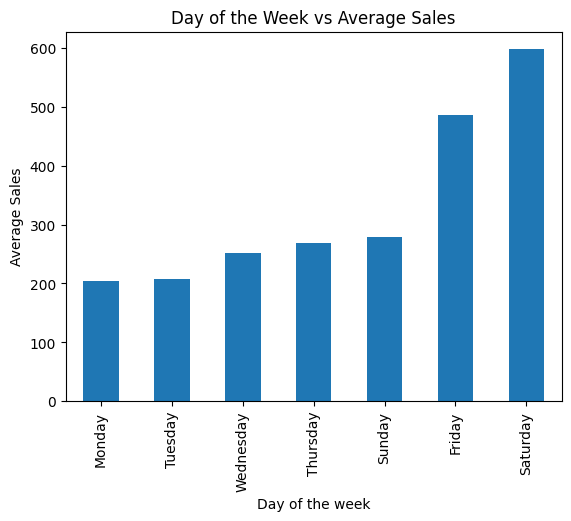

In [29]:
df_past_2016=df_no_duplicates[df_no_duplicates['date']>='2016-01-01']
week_sales=df_past_2016.groupby('day_of_the_week')['sales'].median()
week_sales=week_sales.sort_values()
week_sales.plot(kind='bar',)
plt.title('Day of the Week vs Average Sales')
plt.xlabel('Day of the week')
plt.ylabel('Average Sales')
plt.show()




In [30]:
def flag_creator(x):
    if x=='Holiday':
        return 'Holiday'
    else:
        return 'Not Holiday'
df_past_2016['Holiday flag']=df_past_2016['type'].apply(flag_creator)
df_past_2016

,id,date,store_nbr,family,sales,onpromotion,Classified_promo_3,day_of_the_week,new_flag,type,Holiday flag
0,1947220,2016-01-01,44,"LIQUOR,WINE,BEER",0.0,0,0,Friday,Low Promotional,Holiday,Holiday
1,1949002,2016-01-02,44,"LIQUOR,WINE,BEER",431.0,0,0,Saturday,Low Promotional,NaN,Not Holiday
2,1950784,2016-01-03,44,"LIQUOR,WINE,BEER",0.0,0,0,Sunday,Low Promotional,NaN,Not Holiday
3,1952566,2016-01-04,44,"LIQUOR,WINE,BEER",261.0,0,0,Monday,Low Promotional,NaN,Not Holiday
4,1954348,2016-01-05,44,"LIQUOR,WINE,BEER",299.0,0,0,Tuesday,Low Promotional,NaN,Not Holiday
...,...,...,...,...,...,...,...,...,...,...,...
602,2993254,2017-08-11,44,"LIQUOR,WINE,BEER",560.0,10,large,Friday,High Promotional,Transfer,Not Holiday
603,2995036,2017-08-12,44,"LIQUOR,WINE,BEER",454.0,8,large,Saturday,High Promotional,NaN,Not Holiday
604,2996818,2017-08-13,44,"LIQUOR,WINE,BEER",252.0,8,large,Sunday,High Promotional,NaN,Not Holiday
605,2998600,2017-08-14,44,"LIQUOR,WINE,BEER",186.0,6,medium,Monday,High Promotional,NaN,Not Holiday


In [31]:
df_past_2016.groupby('Holiday flag')['sales'].median()

Holiday flag
Holiday        301.0
Not Holiday    273.0
Name: sales, dtype: float64

#### We see that Holidays generate higher sales. Therefore, we remove them from the dataset such that it doesn't skew the result

In [32]:
df_drop_holidays=df_no_duplicates[~(df_no_duplicates['type']=='Holiday')]
df_drop_holidays

,id,date,store_nbr,family,sales,onpromotion,Classified_promo_3,day_of_the_week,new_flag,type
1,1949002,2016-01-02,44,"LIQUOR,WINE,BEER",431.0,0,0,Saturday,Low Promotional,NaN
2,1950784,2016-01-03,44,"LIQUOR,WINE,BEER",0.0,0,0,Sunday,Low Promotional,NaN
3,1952566,2016-01-04,44,"LIQUOR,WINE,BEER",261.0,0,0,Monday,Low Promotional,NaN
4,1954348,2016-01-05,44,"LIQUOR,WINE,BEER",299.0,0,0,Tuesday,Low Promotional,NaN
5,1956130,2016-01-06,44,"LIQUOR,WINE,BEER",296.0,0,0,Wednesday,Low Promotional,NaN
...,...,...,...,...,...,...,...,...,...,...
600,2989690,2017-08-09,44,"LIQUOR,WINE,BEER",260.0,4,medium,Wednesday,High Promotional,NaN
602,2993254,2017-08-11,44,"LIQUOR,WINE,BEER",560.0,10,large,Friday,High Promotional,Transfer
603,2995036,2017-08-12,44,"LIQUOR,WINE,BEER",454.0,8,large,Saturday,High Promotional,NaN
604,2996818,2017-08-13,44,"LIQUOR,WINE,BEER",252.0,8,large,Sunday,High Promotional,NaN


In [33]:
df_drop_holidays['new_flag']=((df_drop_holidays['Classified_promo_3']=='medium') | (df_drop_holidays['Classified_promo_3']=='large'))
df_drop_holidays.replace({True: 'High Promotional', False: 'Low Promotional'}, inplace=True)
df_drop_holidays

C:\Users\madha\AppData\Local\Temp\ipykernel_7912\1078220095.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop_holidays['new_flag']=((df_drop_holidays['Classified_promo_3']=='medium') | (df_drop_holidays['Classified_promo_3']=='large'))
C:\Users\madha\AppData\Local\Temp\ipykernel_7912\1078220095.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop_holidays.replace({True: 'High Promotional', False: 'Low Promotional'}, inplace=True)


,id,date,store_nbr,family,sales,onpromotion,Classified_promo_3,day_of_the_week,new_flag,type
1,1949002,2016-01-02,44,"LIQUOR,WINE,BEER",431.0,0,0,Saturday,Low Promotional,NaN
2,1950784,2016-01-03,44,"LIQUOR,WINE,BEER",0.0,0,0,Sunday,Low Promotional,NaN
3,1952566,2016-01-04,44,"LIQUOR,WINE,BEER",261.0,0,0,Monday,Low Promotional,NaN
4,1954348,2016-01-05,44,"LIQUOR,WINE,BEER",299.0,0,0,Tuesday,Low Promotional,NaN
5,1956130,2016-01-06,44,"LIQUOR,WINE,BEER",296.0,0,0,Wednesday,Low Promotional,NaN
...,...,...,...,...,...,...,...,...,...,...
600,2989690,2017-08-09,44,"LIQUOR,WINE,BEER",260.0,4,medium,Wednesday,High Promotional,NaN
602,2993254,2017-08-11,44,"LIQUOR,WINE,BEER",560.0,10,large,Friday,High Promotional,Transfer
603,2995036,2017-08-12,44,"LIQUOR,WINE,BEER",454.0,8,large,Saturday,High Promotional,NaN
604,2996818,2017-08-13,44,"LIQUOR,WINE,BEER",252.0,8,large,Sunday,High Promotional,NaN


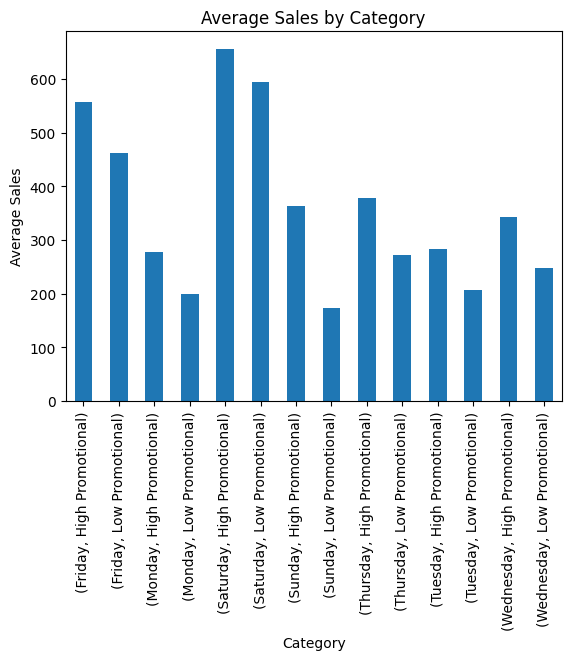

In [34]:
df_drop_holidays_past_2016=df_drop_holidays[df_drop_holidays['date']>='2016-01-01']
average_sales_wo_holiday = df_drop_holidays_past_2016.groupby(['day_of_the_week','new_flag'])['sales'].mean()
average_sales_wo_holiday.plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Average Sales')
plt.title('Average Sales by Category')
plt.show()

#### We see that Weekdays with high promotional activity perform better than days with low promotional activity. Therefore, we focus only on days with High promotional activity

## We drop weekends from the dataset

In [37]:
df_drop_holidays['weekend_flag']=((df_drop_holidays['day_of_the_week']=='Saturday' ) | (df_drop_holidays['day_of_the_week']=='Sunday' ) | (df_drop_holidays['day_of_the_week']=='Friday' ))
df_drop_holidays['weekend_flag'] = df_drop_holidays['weekend_flag'].astype(int)
df_drop_holidays

C:\Users\madha\AppData\Local\Temp\ipykernel_7912\2683793166.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop_holidays['weekend_flag']=((df_drop_holidays['day_of_the_week']=='Saturday' ) | (df_drop_holidays['day_of_the_week']=='Sunday' ) | (df_drop_holidays['day_of_the_week']=='Friday' ))
C:\Users\madha\AppData\Local\Temp\ipykernel_7912\2683793166.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop_holidays['weekend_flag'] = df_drop_holidays['weekend_flag'].astype(int)


,id,date,store_nbr,family,sales,onpromotion,Classified_promo_3,day_of_the_week,new_flag,type,weekend_flag
1,1949002,2016-01-02,44,"LIQUOR,WINE,BEER",431.0,0,0,Saturday,Low Promotional,NaN,1
2,1950784,2016-01-03,44,"LIQUOR,WINE,BEER",0.0,0,0,Sunday,Low Promotional,NaN,1
3,1952566,2016-01-04,44,"LIQUOR,WINE,BEER",261.0,0,0,Monday,Low Promotional,NaN,0
4,1954348,2016-01-05,44,"LIQUOR,WINE,BEER",299.0,0,0,Tuesday,Low Promotional,NaN,0
5,1956130,2016-01-06,44,"LIQUOR,WINE,BEER",296.0,0,0,Wednesday,Low Promotional,NaN,0
...,...,...,...,...,...,...,...,...,...,...,...
600,2989690,2017-08-09,44,"LIQUOR,WINE,BEER",260.0,4,medium,Wednesday,High Promotional,NaN,0
602,2993254,2017-08-11,44,"LIQUOR,WINE,BEER",560.0,10,large,Friday,High Promotional,Transfer,1
603,2995036,2017-08-12,44,"LIQUOR,WINE,BEER",454.0,8,large,Saturday,High Promotional,NaN,1
604,2996818,2017-08-13,44,"LIQUOR,WINE,BEER",252.0,8,large,Sunday,High Promotional,NaN,1


In [38]:
df_drop_holidays=df_drop_holidays[df_drop_holidays['weekend_flag']==0]
df_drop_holidays.head(10)

,id,date,store_nbr,family,sales,onpromotion,Classified_promo_3,day_of_the_week,new_flag,type,weekend_flag
3,1952566,2016-01-04,44,"LIQUOR,WINE,BEER",261.0,0,0,Monday,Low Promotional,NaN,0
4,1954348,2016-01-05,44,"LIQUOR,WINE,BEER",299.0,0,0,Tuesday,Low Promotional,NaN,0
5,1956130,2016-01-06,44,"LIQUOR,WINE,BEER",296.0,0,0,Wednesday,Low Promotional,NaN,0
6,1957912,2016-01-07,44,"LIQUOR,WINE,BEER",226.0,0,0,Thursday,Low Promotional,NaN,0
10,1965040,2016-01-11,44,"LIQUOR,WINE,BEER",257.0,0,0,Monday,Low Promotional,NaN,0
11,1966822,2016-01-12,44,"LIQUOR,WINE,BEER",181.0,0,0,Tuesday,Low Promotional,NaN,0
12,1968604,2016-01-13,44,"LIQUOR,WINE,BEER",212.0,0,0,Wednesday,Low Promotional,NaN,0
13,1970386,2016-01-14,44,"LIQUOR,WINE,BEER",268.0,0,0,Thursday,Low Promotional,NaN,0
17,1977514,2016-01-18,44,"LIQUOR,WINE,BEER",172.0,0,0,Monday,Low Promotional,NaN,0
18,1979296,2016-01-19,44,"LIQUOR,WINE,BEER",169.0,0,0,Tuesday,Low Promotional,NaN,0


In [40]:
average_sales=df_drop_holidays['sales'].mean()
average_sales

257.0485436893204

### Flagging days with Above average sales as 

In [41]:
df_drop_holidays['Above_Average']=df_drop_holidays['sales'] > average_sales
df_drop_holidays['Above_Average'] = df_drop_holidays['Above_Average'].astype(int)
df_drop_holidays.head()

C:\Users\madha\AppData\Local\Temp\ipykernel_7912\887275094.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop_holidays['Above_Average']=df_drop_holidays['sales'] > average_sales
C:\Users\madha\AppData\Local\Temp\ipykernel_7912\887275094.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_drop_holidays['Above_Average'] = df_drop_holidays['Above_Average'].astype(int)


,id,date,store_nbr,family,sales,onpromotion,Classified_promo_3,day_of_the_week,new_flag,type,weekend_flag,Above_Average
3,1952566,2016-01-04,44,"LIQUOR,WINE,BEER",261.0,0,0,Monday,Low Promotional,NaN,0,1
4,1954348,2016-01-05,44,"LIQUOR,WINE,BEER",299.0,0,0,Tuesday,Low Promotional,NaN,0,1
5,1956130,2016-01-06,44,"LIQUOR,WINE,BEER",296.0,0,0,Wednesday,Low Promotional,NaN,0,1
6,1957912,2016-01-07,44,"LIQUOR,WINE,BEER",226.0,0,0,Thursday,Low Promotional,NaN,0,0
10,1965040,2016-01-11,44,"LIQUOR,WINE,BEER",257.0,0,0,Monday,Low Promotional,NaN,0,0


In [42]:
average_sales_wo_holiday = df_drop_holidays.groupby(['day_of_the_week','Classified_promo_3','Above_Average'])['sales'].count()
average_sales_wo_holiday


day_of_the_week  Classified_promo_3  Above_Average
Monday           0                   0                33
                                     1                 2
                 large               0                 1
                                     1                 2
                 low                 0                22
                                     1                 1
                 medium              0                14
                                     1                 3
Thursday         0                   0                10
                                     1                12
                 large               1                 4
                 low                 0                13
                                     1                17
                 medium              0                 4
                                     1                15
Tuesday          0                   0                25
                                     

#### We subset the data into different weekdays with "High promotional activity" which will further be used for Statistical Hypotheis testing and Bayesian Hypotheis testing

In [51]:
wednesday_dataset=df_drop_holidays[df_drop_holidays['day_of_the_week']=='Wednesday' ]
wednesday_dataset['flag_promo']=(((wednesday_dataset['Classified_promo_3']=='medium') | (wednesday_dataset['Classified_promo_3']=='large')) & (wednesday_dataset['Above_Average']==1)) 
wednesday_dataset['flag_promo']=wednesday_dataset['flag_promo'].astype(int)
wednesday_dataset=wednesday_dataset[((wednesday_dataset['Classified_promo_3']=='medium') | (wednesday_dataset['Classified_promo_3']=='large'))]
wednesday_dataset.groupby(['flag_promo','Classified_promo_3'])['id'].count()

C:\Users\madha\AppData\Local\Temp\ipykernel_7912\2268570825.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wednesday_dataset['flag_promo']=(((wednesday_dataset['Classified_promo_3']=='medium') | (wednesday_dataset['Classified_promo_3']=='large')) & (wednesday_dataset['Above_Average']==1))
C:\Users\madha\AppData\Local\Temp\ipykernel_7912\2268570825.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  wednesday_dataset['flag_promo']=wednesday_dataset['flag_promo'].astype(int)


flag_promo  Classified_promo_3
0           medium                 6
1           large                  4
            medium                12
Name: id, dtype: int64

In [52]:
tuesday_dataset=df_drop_holidays[df_drop_holidays['day_of_the_week']=='Tuesday' ]

tuesday_dataset['flag_promo']=(((tuesday_dataset['Classified_promo_3']=='medium') | (tuesday_dataset['Classified_promo_3']=='large')) & (tuesday_dataset['Above_Average']==1)) 
tuesday_dataset['flag_promo']=tuesday_dataset['flag_promo'].astype(int)
tuesday_dataset=tuesday_dataset[((tuesday_dataset['Classified_promo_3']=='medium') | (tuesday_dataset['Classified_promo_3']=='large'))]

tuesday_dataset.groupby(['flag_promo','Classified_promo_3'])['id'].count()

C:\Users\madha\AppData\Local\Temp\ipykernel_7912\1045020534.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tuesday_dataset['flag_promo']=(((tuesday_dataset['Classified_promo_3']=='medium') | (tuesday_dataset['Classified_promo_3']=='large')) & (tuesday_dataset['Above_Average']==1))
C:\Users\madha\AppData\Local\Temp\ipykernel_7912\1045020534.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  tuesday_dataset['flag_promo']=tuesday_dataset['flag_promo'].astype(int)


flag_promo  Classified_promo_3
0           medium                16
1           large                  2
            medium                 7
Name: id, dtype: int64

In [53]:
thursday_dataset=df_drop_holidays[df_drop_holidays['day_of_the_week']=='Thursday' ]
thursday_dataset['flag_promo']=(((thursday_dataset['Classified_promo_3']=='medium') | (thursday_dataset['Classified_promo_3']=='large')) & (thursday_dataset['Above_Average']==1)) 
thursday_dataset['flag_promo']=thursday_dataset['flag_promo'].astype(int)
thursday_dataset=thursday_dataset[((thursday_dataset['Classified_promo_3']=='medium') | (thursday_dataset['Classified_promo_3']=='large'))]

thursday_dataset.groupby(['flag_promo','Classified_promo_3'])['id'].count()

C:\Users\madha\AppData\Local\Temp\ipykernel_7912\1529255809.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thursday_dataset['flag_promo']=(((thursday_dataset['Classified_promo_3']=='medium') | (thursday_dataset['Classified_promo_3']=='large')) & (thursday_dataset['Above_Average']==1))
C:\Users\madha\AppData\Local\Temp\ipykernel_7912\1529255809.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  thursday_dataset['flag_promo']=thursday_dataset['flag_promo'].astype(int)


flag_promo  Classified_promo_3
0           medium                 4
1           large                  4
            medium                15
Name: id, dtype: int64

In [54]:
monday_dataset=df_drop_holidays[df_drop_holidays['day_of_the_week']=='Monday' ]
monday_dataset['flag_promo']=(((monday_dataset['Classified_promo_3']=='medium') | (monday_dataset['Classified_promo_3']=='large')) & (monday_dataset['Above_Average']==1)) 
monday_dataset['flag_promo']=monday_dataset['flag_promo'].astype(int)
monday_dataset=monday_dataset[((monday_dataset['Classified_promo_3']=='medium') | (monday_dataset['Classified_promo_3']=='large'))]

monday_dataset.groupby(['flag_promo','Classified_promo_3'])['id'].count()

C:\Users\madha\AppData\Local\Temp\ipykernel_7912\3841228142.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monday_dataset['flag_promo']=(((monday_dataset['Classified_promo_3']=='medium') | (monday_dataset['Classified_promo_3']=='large')) & (monday_dataset['Above_Average']==1))
C:\Users\madha\AppData\Local\Temp\ipykernel_7912\3841228142.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  monday_dataset['flag_promo']=monday_dataset['flag_promo'].astype(int)


flag_promo  Classified_promo_3
0           large                  1
            medium                14
1           large                  2
            medium                 3
Name: id, dtype: int64

### Statistical Hypothesis Testing

In [70]:
from scipy import stats
datasets=[monday_dataset, tuesday_dataset, wednesday_dataset, thursday_dataset  ]
days=['MN', 'TU', 'WD' , 'TH']
days_print=['Days ','MN', 'TU', 'WD' , 'TH']
p_value_list=[]
p_value_list.append(days_print)
for i,k in zip(datasets,days):
    temp_list=[]
    temp_list.append(k)
    
    
    for j in datasets:
        group1=i['sales']
        group2=j['sales']
        t_stat, p_value = stats.ttest_ind(group1, group2)
        temp_list.append(p_value.round(4))
    p_value_list.append(temp_list)
p_value_list   

[['Days ', 'MN', 'TU', 'WD', 'TH'],
 ['MN', 1.0, 0.9077, 0.279, 0.0819],
 ['TU', 0.9077, 1.0, 0.2705, 0.0674],
 ['WD', 0.279, 0.2705, 1.0, 0.5575],
 ['TH', 0.0819, 0.0674, 0.5575, 1.0]]

### We can see no day has sales significantly different from one another

### We therefore perform Bayesian analysis to find the best possible day to roll out high promotions

### Approach:
##### 1) We flag weekdays with high Promotional activity and above average sales as success (1) and weekdays with low Promotional activity and below average sales as failure (0)
##### 2) We use a Beta(5,5) as a prior, which believes equal probability of success
##### 3) We use Beta-Binomial conjugate distribution here to get the posterior probability
##### 4) The posterior Beta probability distribution establishes the probability of success, given equal prior belief

In [72]:
monday_array=np.array(monday_dataset['flag_promo'])
monday_array

array([0, 0, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [73]:
monday_count_positive= np.count_nonzero(monday_array == 1)
monday_count_positive

5

In [74]:
wednesday_array=np.array(wednesday_dataset['flag_promo'])
wednesday_array

array([1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1])

In [75]:
wednesday_count_positive= np.count_nonzero(wednesday_array == 1)
wednesday_count_positive

16

In [76]:
tuesday_array=np.array(tuesday_dataset['flag_promo'])
tuesday_array

array([0, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1,
       0, 1, 0])

In [77]:
tuesday_count_positive= np.count_nonzero(tuesday_array == 1)
tuesday_count_positive

9

In [78]:
thursday_array=np.array(thursday_dataset['flag_promo'])
thursday_array

array([1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1,
       1])

#### Using PyMC3 to get the posterior probability for Monday

C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [prior_success_prob]


C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\theano\scalar\basic.py:2851: RuntimeWarning: divide by zero encountered in true_divide
  return np.float32(1.0) / x
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\theano\scalar\basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)
Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 28 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\arviz\data\io_pymc3_3x.py:98: Futur

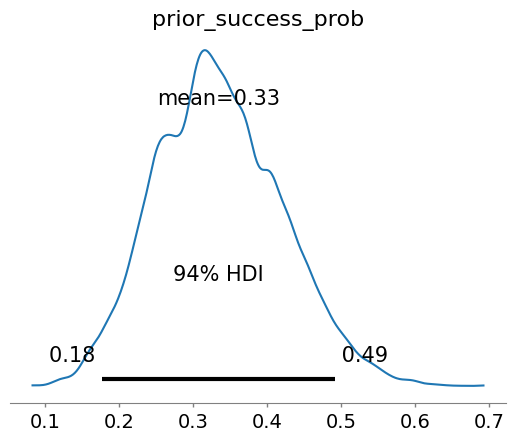

In [80]:
# Generate some example data
np.random.seed(42)


# Define the PyMC3 model
with pm.Model() as beta_binomial_model:
    # Prior distribution for the success probability (Beta distribution)
    prior_success_prob = pm.Beta('prior_success_prob', alpha=5, beta=5)
    
    # Likelihood (Binomial distribution)
    likelihood = pm.Binomial('likelihood', n=len(monday_array), p=prior_success_prob, observed=monday_count_positive)

# Perform sampling
with beta_binomial_model:
    monday_trace = pm.sample(4000, tune=1000, cores=1)  # You may need to adjust 'cores' based on your system

# Plot the posterior distribution of the success probability
pm.plot_posterior(monday_trace, var_names=['prior_success_prob'])
plt.show()

C:\Users\madha\AppData\Local\Temp\ipykernel_7912\2492165074.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(monday_trace)
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


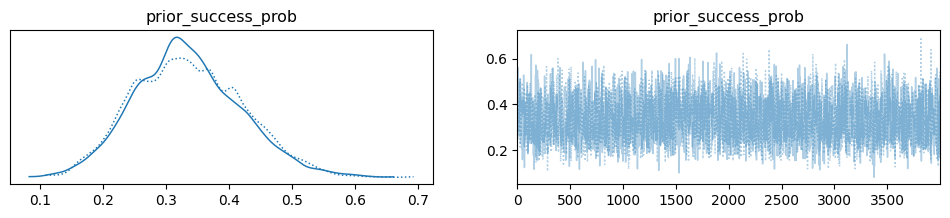

In [81]:
pm.traceplot(monday_trace)
pass

In [82]:
pm.summary(monday_trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior_success_prob,0.335,0.085,0.177,0.492,0.001,0.001,3273.0,5859.0,1.0


#### Estimating posterior Alpha and Beta Parameters

In [69]:
def estBetaParams  (mu, sd):
    var=sd**2
    alpha = ((1 - mu) / var - 1 / mu) * mu ** 2
    beta = alpha * (1 / mu - 1)
    return alpha, beta
estBetaParams(0.335,0.085)

(9.994359861591697, 19.83955017301038)

In [89]:
with beta_binomial_model:
    ps = pm.sample_prior_predictive(samples=1000000)

In [90]:
import seaborn as sns

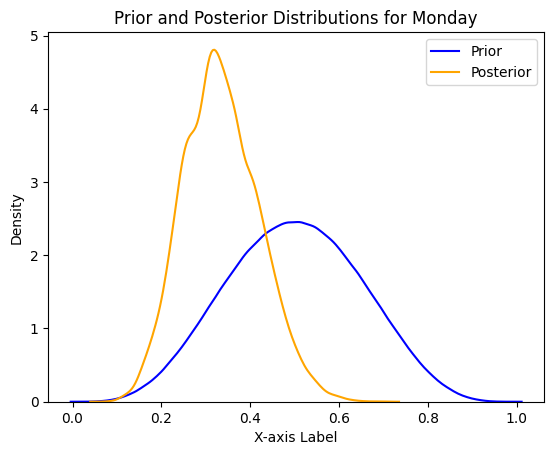

In [91]:
# Create density plots
sns.kdeplot(ps['prior_success_prob'], label='Prior', color='blue')
sns.kdeplot(monday_trace.get_values('prior_success_prob'), label='Posterior', color='orange')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Density')
plt.title('Prior and Posterior Distributions for Monday')

# Add legend
plt.legend()

# Show the plot
plt.show()

### We saw a backward shift from prior Beta(5,5). This signifies higher chances of failure than success. We can say from the descriptive statistics that the chances of success is close to 34%

## We now get the posterior probability for Tuesday

C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [prior_success_prob]


Sampling 2 chains for 1_000 tune and 4_000 draw iterations (2_000 + 8_000 draws total) took 28 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


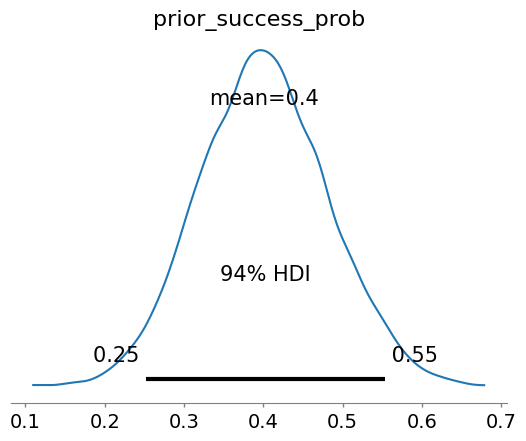

In [93]:
# Generate some example data
np.random.seed(32)


# Define the PyMC3 model
with pm.Model() as beta_binomial_model:
    # Prior distribution for the success probability (Beta distribution)
    prior_success_prob = pm.Beta('prior_success_prob', alpha=5, beta=5)
    
    # Likelihood (Binomial distribution)
    likelihood = pm.Binomial('likelihood', n=len(tuesday_array), p=prior_success_prob, observed=tuesday_count_positive)

# Perform sampling
with beta_binomial_model:
    tuesday_trace = pm.sample(4000, tune=1000, cores=1)  # You may need to adjust 'cores' based on your system

# Plot the posterior distribution of the success probability
pm.plot_posterior(tuesday_trace, var_names=['prior_success_prob'])
plt.show()

C:\Users\madha\AppData\Local\Temp\ipykernel_7912\2962462364.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(tuesday_trace)
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


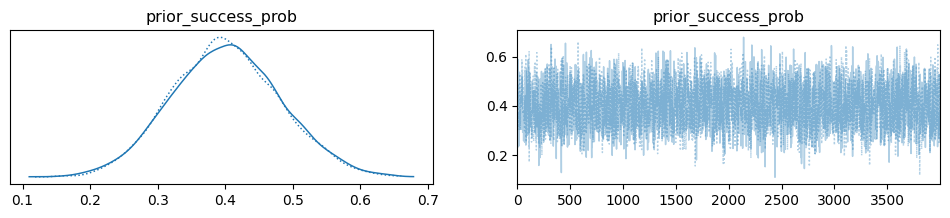

In [94]:
pm.traceplot(tuesday_trace)
pass

In [95]:
pm.summary(tuesday_trace)


Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior_success_prob,0.401,0.081,0.252,0.553,0.001,0.001,3558.0,5315.0,1.0


In [96]:
def estBetaParams  (mu, sd):
    var=sd**2
    alpha = ((1 - mu) / var - 1 / mu) * mu ** 2
    beta = alpha * (1 / mu - 1)
    return alpha, beta
estBetaParams(0.343,0.078)

(12.361699704142014, 23.678241124260357)

In [102]:
with beta_binomial_model:
    ps = pm.sample_prior_predictive(samples=1000000)


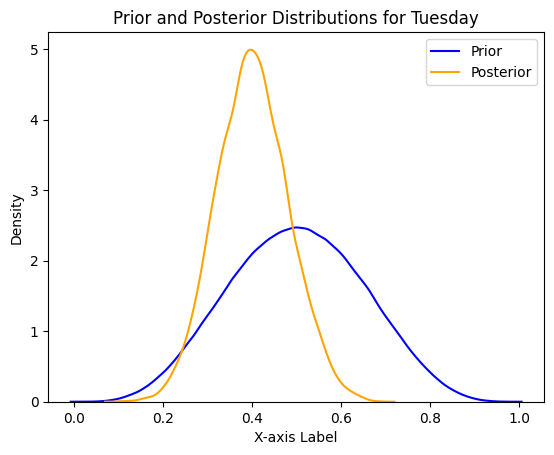

In [103]:
# Create density plots
sns.kdeplot(ps['prior_success_prob'], label='Prior', color='blue')
sns.kdeplot(tuesday_trace.get_values('prior_success_prob'), label='Posterior', color='orange')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Density')
plt.title('Prior and Posterior Distributions for Tuesday')

# Add legend
plt.legend()

# Show the plot
plt.show()

#### We see a negative shift again, and we observe only a 40% probability of getting above average sales if high promotional activity is rolled out

### We now check the posterior probability for Wednesday

C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [prior_success_prob]


C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\theano\scalar\basic.py:2851: RuntimeWarning: divide by zero encountered in true_divide
  return np.float32(1.0) / x
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\theano\scalar\basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 35 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


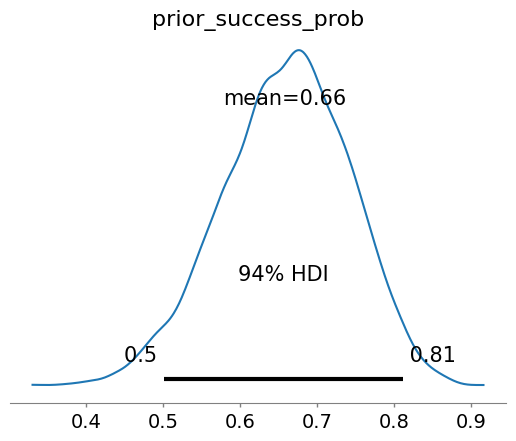

In [111]:
# Generate some example data
np.random.seed(42)


# Define the PyMC3 model
with pm.Model() as beta_binomial_model:
    # Prior distribution for the success probability (Beta distribution)
    prior_success_prob = pm.Beta('prior_success_prob', alpha=5, beta=5)
    
    # Likelihood (Binomial distribution)
    likelihood = pm.Binomial('likelihood', n=len(wednesday_array), p=prior_success_prob, observed=wednesday_count_positive)

# Perform sampling
with beta_binomial_model:
    wednesday_trace = pm.sample(5000, tune=1000, cores=1)  # You may need to adjust 'cores' based on your system

# Plot the posterior distribution of the success probability
pm.plot_posterior(wednesday_trace, var_names=['prior_success_prob'])
plt.show()

In [112]:
pm.summary(wednesday_trace)

Got error No model on context stack. trying to find log_likelihood in translation.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior_success_prob,0.658,0.083,0.501,0.811,0.001,0.001,4444.0,6886.0,1.0


In [113]:
def estBetaParams  (mu, sd):
    var=sd**2
    alpha = ((1 - mu) / var - 1 / mu) * mu ** 2
    beta = alpha * (1 / mu - 1)
    return alpha, beta
estBetaParams(0.534,0.087)

(17.02217598097503, 14.85455806579469)

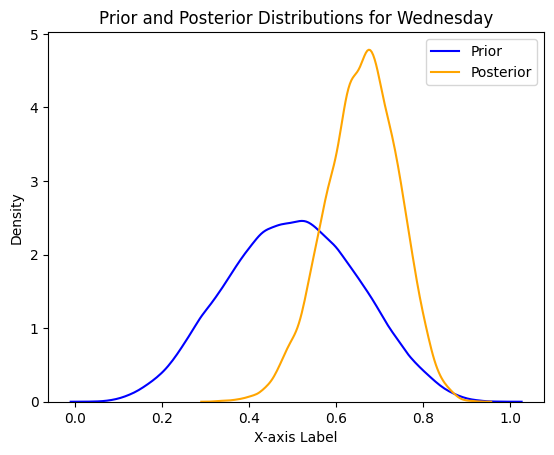

In [114]:
# Create density plots
sns.kdeplot(ps['prior_success_prob'], label='Prior', color='blue')
sns.kdeplot(wednesday_trace.get_values('prior_success_prob'), label='Posterior', color='orange')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Density')
plt.title('Prior and Posterior Distributions for Wednesday')

# Add legend
plt.legend()

# Show the plot
plt.show()

#### We can observe a positive shift in posterior probability. we can say that on Wednesday, the average chance of achieving high promotional activity is 66%

### We now check the posterior probability for Thursday

C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\deprecat\classic.py:215: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  return wrapped_(*args_, **kwargs_)
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [prior_success_prob]


C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\theano\scalar\basic.py:2851: RuntimeWarning: divide by zero encountered in true_divide
  return np.float32(1.0) / x
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\numpy\core\fromnumeric.py:86: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\theano\tensor\elemwise.py:826: RuntimeWarning: invalid value encountered in impl (vectorized)
  variables = ufunc(*ufunc_args, **ufunc_kwargs)
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\theano\scalar\basic.py:3023: RuntimeWarning: divide by zero encountered in log1p
  return np.log1p(x)
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\theano\scalar\basic.py:2893: RuntimeWarning: divide by zero encountered in log
  return np.log(x)


Sampling 2 chains for 1_000 tune and 5_000 draw iterations (2_000 + 10_000 draws total) took 35 seconds.
Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


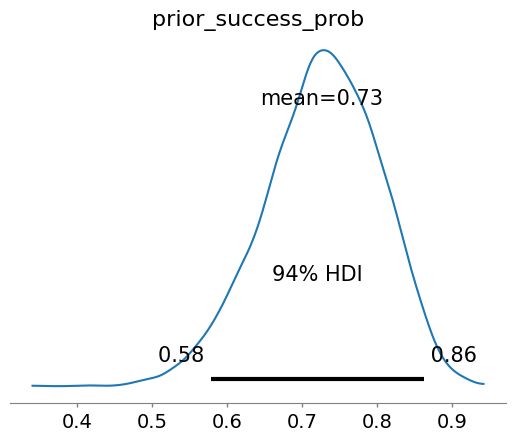

In [104]:
# Generate some example data
np.random.seed(42)


# Define the PyMC3 model
with pm.Model() as beta_binomial_model:
    # Prior distribution for the success probability (Beta distribution)
    prior_success_prob = pm.Beta('prior_success_prob', alpha=5, beta=5)
    
    # Likelihood (Binomial distribution)
    likelihood = pm.Binomial('likelihood', n=len(thursday_array), p=prior_success_prob, observed=thursday_count_positive)

# Perform sampling
with beta_binomial_model:
    thursday_trace = pm.sample(5000, tune=1000, cores=1)  # You may need to adjust 'cores' based on your system

# Plot the posterior distribution of the success probability
pm.plot_posterior(thursday_trace, var_names=['prior_success_prob'])
plt.show()

C:\Users\madha\AppData\Local\Temp\ipykernel_7912\603487603.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(thursday_trace)
Got error No model on context stack. trying to find log_likelihood in translation.
Got error No model on context stack. trying to find log_likelihood in translation.


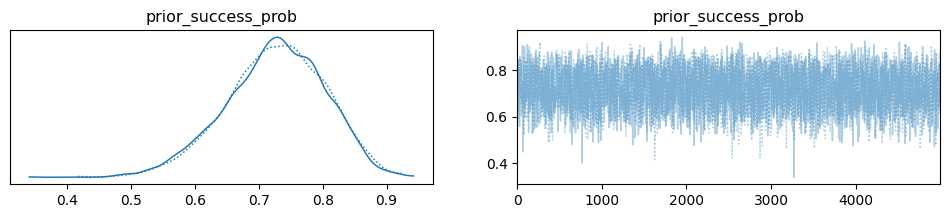

In [105]:
pm.traceplot(thursday_trace)
pass

In [106]:
pm.summary(thursday_trace)

Got error No model on context stack. trying to find log_likelihood in translation.
C:\Users\madha\.conda\envs\bayesian_2\lib\site-packages\arviz\data\io_pymc3_3x.py:98: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
prior_success_prob,0.726,0.077,0.579,0.863,0.001,0.001,4274.0,6230.0,1.0


In [108]:
with beta_binomial_model:
    ps = pm.sample_prior_predictive(samples=100000)

In [109]:
def estBetaParams  (mu, sd):
    var=sd**2
    alpha = ((1 - mu) / var - 1 / mu) * mu ** 2
    beta = alpha * (1 / mu - 1)
    return alpha, beta
estBetaParams(0.637,0.082)

(21.268732748364066, 12.12017266508031)

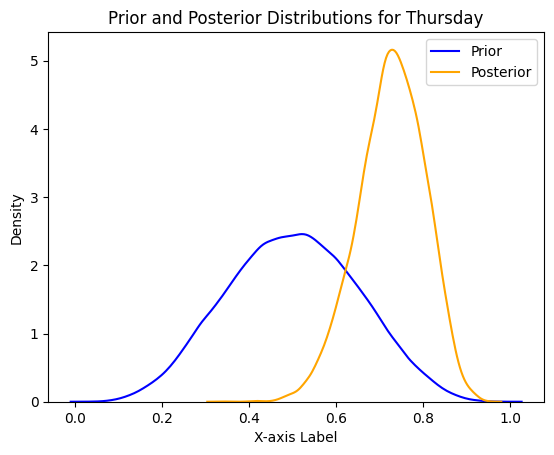

In [110]:
# Create density plots
sns.kdeplot(ps['prior_success_prob'], label='Prior', color='blue')
sns.kdeplot(thursday_trace.get_values('prior_success_prob'), label='Posterior', color='orange')

# Add labels and title
plt.xlabel('X-axis Label')
plt.ylabel('Density')
plt.title('Prior and Posterior Distributions for Thursday')

# Add legend
plt.legend()

# Show the plot
plt.show()

#### We can observe a positive shift in posterior probability. we can say that on thursday, the average chance of achieving high promotional activity is 73%

## Conclusion:
#### We can therefore infer from the Bayesian analysis, that the average chance of achiveing above average sales on rolling out high promotions is highest for Thursday at 73%. While, Wednesday comes close too
#### We can roll out promotions for 2 months on these 2 days and perform A/B testing
#### We can use this frame work to update probabilities as more data is available to determine which among the 2 days is best to rollout the high promotions